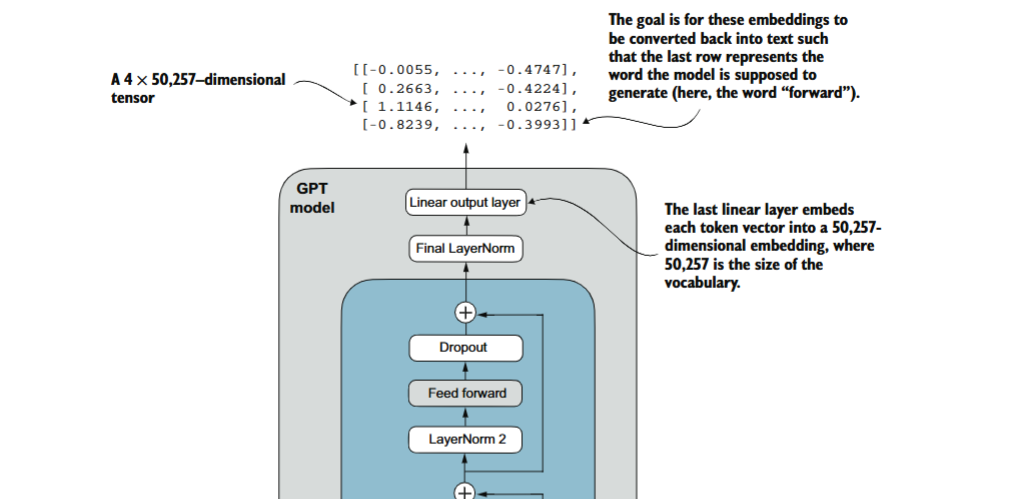
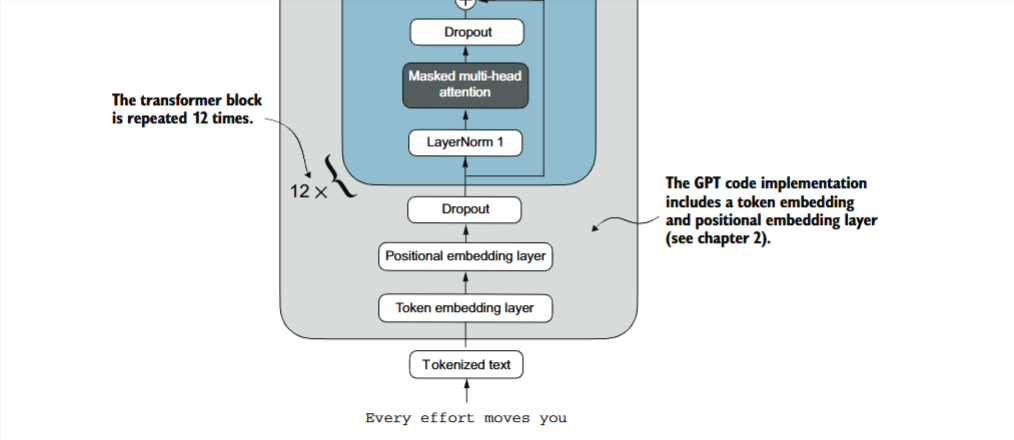

I have coded the full architecture below. I am not explaining each things because we have seen the things well enough in previous chapters

In [ ]:
import torch
import torch.nn as nn

In [ ]:
GPT_CONFIG_124M = {
    'vocab_size' : 50257,
    'emb_dim' : 768,
    'context_length' : 1024,
    'n_heads' : 12,
    'n_layers' : 12,
    'dropout_rate' : 0.1,
    'qkv_bias' : False,
    'model_name' : 'gpt-2'
}

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
      super().__init__() # d_in, d_out, context_length, dropout, num_heads, qkv_bias=False
      self.attn = MultiHeadAttention(cfg['emb_dim'], cfg['emb_dim'], cfg['context_length'], cfg['dropout_rate'], cfg['n_heads'], cfg['qkv_bias'])
      self.ffn = FeedForward(cfg)
      self.norm1 = nn.LayerNorm(cfg['emb_dim'])
      self.norm2 = nn.LayerNorm(cfg['emb_dim'])
      self.dropout = nn.Dropout(cfg['dropout_rate'])

  def forward(self, x):
      shortcut = x
      x = self.norm1(x)
      x = self.attn(x)
      x = self.dropout(x)
      x = shortcut + x

      shortcut = x
      x = self.norm2(x)
      x = self.ffn(x)
      x = self.dropout(x)
      x = shortcut + x

      return x

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
      super().__init__()
      self.token_embedding = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
      self.positional_embedding = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
      self.dropout = nn.Dropout(cfg['dropout_rate'])

      self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

      self.final_norm = nn.LayerNorm(cfg['emb_dim'])
      self.lm_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, x):
      batch_size, seq_len = x.shape
      token_embeddings = self.token_embedding(x)
      position_embeddings = self.positional_embedding(torch.arange(seq_len, device=x.device))
      input_embeddings = token_embeddings + position_embeddings
      x = self.dropout(input_embeddings)
      x = self.trf_blocks(x)
      x = self.final_norm(x)
      x = self.lm_head(x)
      return x

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.2241, -0.0699,  0.5900,  ..., -1.6219, -0.4341,  0.2158],
         [ 0.3750,  0.9353,  0.4675,  ..., -0.3525, -0.4096, -0.0167],
         [-0.3879,  0.3680, -0.4265,  ..., -0.5520, -0.5114, -1.1418],
         [ 0.4656,  0.2113, -0.5303,  ..., -0.2732,  0.2993,  1.1063]],

        [[ 0.4269,  0.1350,  0.7566,  ..., -0.9104, -0.4832,  0.1874],
         [ 0.3693,  0.3638,  0.0882,  ...,  0.2008, -0.4125,  0.0865],
         [-0.8100,  0.8562, -0.4412,  ...,  0.7191, -0.5261,  0.2490],
         [ 0.1304,  0.0827, -0.7556,  ...,  0.3020, -0.1089,  1.4061]]],
       grad_fn=<UnsafeViewBackward0>)


At the very end of a GPT model, after all the attention blocks and feedforward networks have done their job, we need to convert the processed embeddings back into something meaningful: predictions over the vocabulary.

That’s where the final linear layer comes in. It maps each token’s embedding to a vector whose size equals the vocabulary size. For GPT-2, the vocabulary contains 50,257 tokens.

So if our model processes a batch of input sequences, the output logits will have the shape:
(batch_size, sequence_length, vocab_size)

Now let’s decode this shape step by step:



*   2 (batch size) → We gave the model 2 sequences at once. That’s why the first dimension is 2. Each row corresponds to one input example.
*   4 (sequence length) → Each sequence had 4 tokens. For every token, the model produces predictions. So we have 4 “prediction steps” per sequence.

*   50257 (vocabulary size) → For each token position, the model outputs a score (logit) for every word/token in the vocabulary. That means for each of the 4 tokens, the model has an opinion about all 50k+ possible words it could generate next.

---

Still confused? No worries, let’s put it into words:

Imagine you are writing a sentence. At each step (each token), GPT is trying to guess what the next word could be. But it doesn’t just guess one word—it gives a probability distribution over every possible word in its vocabulary.

- For the first token in sequence 1, it outputs a vector of 50,257 scores.

- For the second token, again 50,257 scores.

- And so on, for all 4 tokens, in both sequences.

So the shape [2, 4, 50257] means:

- 2 sequences in a batch

- 4 tokens per sequence

- 50257 possible next words per token

Once we apply a softmax to these logits, they turn into probabilities that sum up to 1 across the vocabulary. That’s how GPT “chooses” the most likely next word.





#### Text Generation

![image.png]()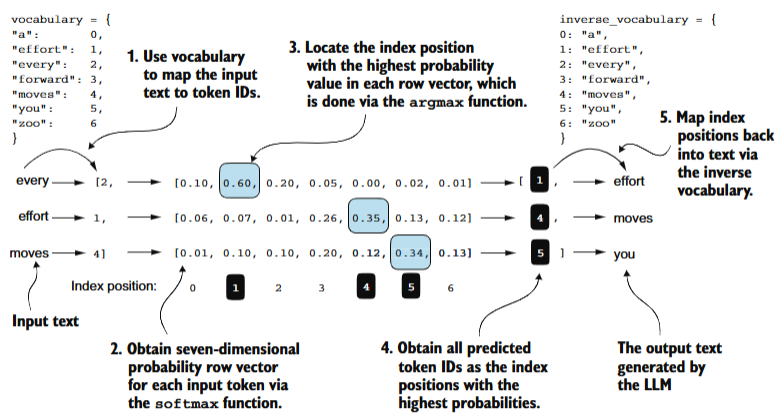

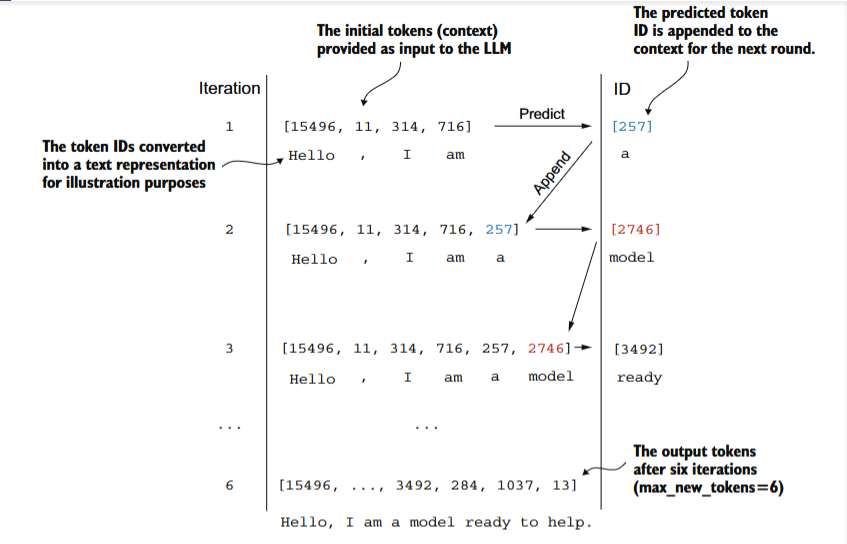

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    probabilities = torch.softmax(logits, dim=-1)
    next_token = torch.multinomial(probabilities, num_samples=1)
    idx = torch.cat((idx, next_token), dim=1)
  return idx

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


<div class="alert alert-block alert-success">
Next, we put the model into .eval() mode, which disables random components like
dropout, which are only used during training, and use the generate_text_simple function
on the encoded input tensor:
</div>

<div class="alert alert-block alert-info">

We disable dropout since we are not training the model

</div>

In [ ]:
model.eval() #A
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 12794,  3627, 42333, 32620, 45724, 25901]])
Output length: 10


In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am cort ignBrausting Qiaoatibility


In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youended Sven BakeOLOG sizes override boots narc Neuro Chelsea


---

<div class="alert alert-block alert-success">

Previously, inside the generate_text_simple function, we always sampled the token
with the highest probability as the next token using torch.argmax, also known as greedy
decoding.

To generate text with more variety, we can replace the argmax with a function
that samples from a probability distribution (here, the probability scores the LLM generates
for each vocabulary entry at each token generation step).

</div>

<div class="alert alert-block alert-success">

To illustrate the probabilistic sampling with a concrete example, let's briefly discuss the
next-token generation process using a very small vocabulary for illustration purposes:

</div>

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

<div class="alert alert-block alert-success">

Next, assume the LLM is given the start context "every effort moves you" and
generates the following next-token logits:

</div>

In [ ]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

<div class="alert alert-block alert-success">

As discussed in the previous chapter, inside the generate_text_simple, we convert the
logits into probabilities via the softmax function and obtain the token ID corresponding the
generated token via the argmax function, which we can then map back into text via the
inverse vocabulary:

</div>

In [ ]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


<div class="alert alert-block alert-success">

To implement a probabilistic sampling process, we can now replace the argmax with the
multinomial function in PyTorch:

</div>

In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


<div class="alert alert-block alert-success">

The printed output is "forward" just like before. What happened? The multinomial
function samples the next token proportional to its probability score.

In other words,
"forward" is still the most likely token and will be selected by multinomial most of the
time but not all the time.

To illustrate this, let's implement a function that repeats this
sampling 1000 times:

</div>

In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


<div class="alert alert-block alert-info">

As we can see based on the output, the word "forward" is sampled most of the time (582
out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also
be sampled some of the time.

This means that if we replaced the argmax function with the
multinomial function inside the generate_and_print_sample function, the LLM would
sometimes generate texts such as "every effort moves you toward", "every effort
moves you inches", and "every effort moves you closer" instead of "every effort
moves you forward".
    
</div>

<div class="alert alert-block alert-success">

We can further control the distribution and selection process via a concept called
temperature scaling, where temperature scaling is just a fancy description for dividing the
logits by a number greater than 0:

</div>

<div class="alert alert-block alert-success">

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values:

</div>

In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

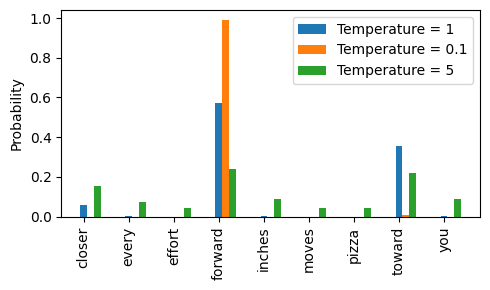

In [ ]:
# Plotting
import matplotlib.pyplot as plt
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

<div class="alert alert-block alert-info">

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores.

In other words, using a temperature of 1 is the same as not
using any temperature scaling.

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    
</div>

<div class="alert alert-block alert-info">

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function.

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often.

This can add more variety to the
generated texts but also more often results in nonsensical text.

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.
    
</div>

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [ ]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rates683 tried Juven hospitalized electedotoninTurnageddon Breed plummeteduberty emanc gloomy Mormon


#### Parameters of the model

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


<div class="alert alert-block alert-danger">
Earlier, we spoke of initializing a 124
million parameter GPT model, so why is the actual number of parameters 163 million, as
shown in the preceding code output?
</div>

<div class="alert alert-block alert-warning">
    
The reason is a concept called weight tying that is used in the original GPT-2
architecture, which means that the original GPT-2 architecture is reusing the weights from
the token embedding layer in its output layer.

To understand what this means, let's take a
look at the shapes of the token embedding layer and linear output layer that we initialized
on the model via the GPTModel earlier:

</div>

In [ ]:
print("Token embedding layer shape:", model.token_embedding.weight.shape)
print("Output layer shape:", model.lm_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


<div class="alert alert-block alert-info">

As we can see based on the print outputs, the weight tensors for both these layers have the
same shape:
</div>

<div class="alert alert-block alert-success">
The token embedding and output layers are very large due to the number of rows for the
50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from
the total GPT-2 model count according to the weight tying:
</div>

In [ ]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.lm_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


<div class="alert alert-block alert-info">

As we can see, the model is now only 124 million parameters large, matching the original
size of the GPT-2 model.
</div>

<div class="alert alert-block alert-warning">
    
Weight tying reduces the overall memory footprint and computational complexity of the
model. However, in my experience, using separate token embedding and output layers
results in better training and model performance; hence, we are using separate layers in
our GPTModel implementation. The same is true for modern LLMs.

</div>

In [ ]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


#### Loss Function

Till now, we have managed to build our model, but its predictions look random and disconnected. That’s expected, because the model’s weights are still untrained. To improve this, we need to train it. And to train a model, the most important concept is the loss function—this is how we measure how wrong the model is, so it knows how to improve.

Let’s explore this with a small example.

Suppose we have an inputs tensor that contains the token IDs for two training examples. Alongside, we have targets, which are the token IDs we actually want the model to produce. Notice that the targets are simply the inputs shifted by one position. This “shifted targets” setup is what allows the model to learn “the next word” prediction.

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

When we feed the inputs to the model, it produces logits. Each token in each input is represented by a vector of size equal to the vocabulary (50,257 in our case). Applying the softmax function converts these logits into probabilities, giving us a distribution over the vocabulary for each token.

In [ ]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape) # (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


Now, if we pick the most likely token ID for each position using argmax, we can see what the model predicts:

In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[ 3922],
         [45418],
         [17733]],

        [[28813],
         [27941],
         [39318]]])


If we decode these tokens, it’s clear that they are very different from our targets. This mismatch is the motivation for training: the model must learn to get closer to the targets.

In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


Targets batch 1:  effort moves you
Outputs batch 1: ilies930thereum


**From Probabilities to Loss**

Let’s look at how well the model did. For each target token, we can check what probability the model assigned to it:

In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)


Text 1: tensor([1.3467e-05, 1.7976e-05, 2.9491e-05])
Text 2: tensor([1.5270e-05, 1.2594e-05, 1.5347e-05])


Ideally, all these numbers should be close to 1, meaning the model is highly confident about the correct token. But currently, they are very small.

A common trick in optimization is to take the logarithm of these probabilities. This makes the math simpler and turns multiplication into addition.

In [ ]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)


tensor([-11.2153, -10.9265, -10.4314, -11.0896, -11.2823, -11.0846])


Next, we compute the average log probability across all tokens:

In [ ]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-11.0049)


The goal of training is to make this average log probability as large as possible (closer to 0, since logs of numbers between 0 and 1 are negative). In deep learning, however, we usually flip the sign and minimize the negative average log probability. This is what we call the cross-entropy loss.

In [ ]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)


tensor(11.0049)


**PyTorch’s Built-In Cross-Entropy**

Instead of writing all of this manually, PyTorch provides a built-in cross_entropy function. It automatically applies softmax, computes log probabilities, and calculates the negative average log likelihood over the target indices.

Before applying it, we just need to reshape our logits and targets into flat tensors:

In [ ]:
print("Logits shape:", logits.shape)   # (batch_size, num_tokens, vocab_size)
print("Targets shape:", targets.shape) # (batch_size, num_tokens)

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


And now, with one line, we get the same result:

In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)


tensor(11.0049)


This value—the cross-entropy loss—is the key signal that tells the model how far it is from the correct predictions. Training the model simply means adjusting the weights so that this loss keeps decreasing.

<div class="alert alert-block alert-success">

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

</div>

In [ ]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(60170.7109)


<div class="alert alert-block alert-info">

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
    
Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution
    
</div>

#### Pre Training the LLM

In [ ]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [ ]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [ ]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


<div class="alert alert-block alert-warning">

With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later).

Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training.
    
For visualization purposes, the figure below assumes a max_length=6, but for the training loader, we set the max_length equal to the context length that the LLM supports.

Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position    
</div>

In [ ]:
train_ratio = 0.9
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
torch.manual_seed(123)

In [ ]:
GPT_CONFIG_124M = {
    'vocab_size' : 50257,
    'emb_dim' : 768,
    'context_length' : 256, # we are reducing from 1024 just for this training purpose
    'n_heads' : 12,
    'n_layers' : 12,
    'dropout_rate' : 0.1,
    'qkv_bias' : False,
    'model_name' : 'gpt-2'
}

In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [ ]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

<div class="alert alert-block alert-info">

We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with.

Llama 2 7B was trained with a batch size of 1024, for example.
    
</div>

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123)

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.97631581624349
Validation loss: 10.98619270324707


In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.positional_embedding.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.930
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.336
Every effort moves you Maggieorb Expl hars neurpackage PROT?"Barspoken, upgradesGeorgeawarurup theOVER includes RIS Cameronorthy Hes  gluc leastsv Raven,sweet that tv crisp Soy G maneuvers-- drive repaylibrary suited 388urdyön heening Dis Rawkat crackingura
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.053
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.604
Every effort moves you the Bergc: Those did he, it Conj laugh sheham-- rich to the hisabsor, a.   unofficial neutral paint'ts-- my, under lifted_ work the about had again outest of the amusing years_is a you
Ep 3 (Step 000020): Train loss 5.527, Val loss 6.511
Ep 3 (Step 000025): Train loss 5.382, Val loss 6.375
Every effort moves youchairs managedantle happened everlasting! spiteOh stay oak Youabytes have up and own Mrsnocket about slipping:He everI had irregular look can a uncertain called caucus a cured looking Iride his 

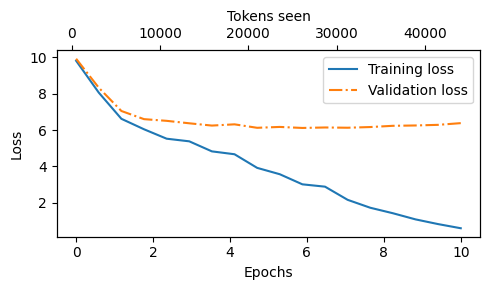

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

This is an indication for overfitting, which is obvious here as we are dealing with millions of parameters by training with this simple data.

But imagine what if we substitute this small data with a huge amount of data, then our model would be so great that it would start to make sense.

The reality is that I don't have millions of dollars to pretrain the model with the whole internet data, but OpenAI has. That's how they built it. So, our next target would be to integrate the gpt-2's open weights to our classes, and instances. We can imagine that we have pretrained on a huge amount of data, which is the resultant open weights.

#### Loading Open Weights from gpt-2 into Our Very Own Model

Let's imagine we don't have any prior code cell. No we have found out how to implement the gpt-2, we are doing every necessary code, and aligning the open weights of OpenAI into our model.

In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
import torch
import torch.nn as nn

In [ ]:
GPT_CONFIG_124M = {
    'vocab_size' : 50257,
    'emb_dim' : 768,
    'context_length' : 1024,
    'n_heads' : 12,
    'n_layers' : 12,
    'dropout_rate' : 0.1,
    'qkv_bias' : False,
    'model_name' : 'gpt-2'
}

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
      super().__init__() # d_in, d_out, context_length, dropout, num_heads, qkv_bias=False
      self.attn = MultiHeadAttention(cfg['emb_dim'], cfg['emb_dim'], cfg['context_length'], cfg['dropout_rate'], cfg['n_heads'], cfg['qkv_bias'])
      self.ffn = FeedForward(cfg)
      self.norm1 = nn.LayerNorm(cfg['emb_dim'])
      self.norm2 = nn.LayerNorm(cfg['emb_dim'])
      self.dropout = nn.Dropout(cfg['dropout_rate'])

  def forward(self, x):
      shortcut = x
      x = self.norm1(x)
      x = self.attn(x)
      x = self.dropout(x)
      x = shortcut + x

      shortcut = x
      x = self.norm2(x)
      x = self.ffn(x)
      x = self.dropout(x)
      x = shortcut + x

      return x

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
      super().__init__()
      self.token_embedding = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
      self.positional_embedding = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
      self.dropout = nn.Dropout(cfg['dropout_rate'])

      self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

      self.final_norm = nn.LayerNorm(cfg['emb_dim'])
      self.lm_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, x):
      batch_size, seq_len = x.shape
      token_embeddings = self.token_embedding(x)
      position_embeddings = self.positional_embedding(torch.arange(seq_len, device=x.device))
      input_embeddings = token_embeddings + position_embeddings
      x = self.dropout(input_embeddings)
      x = self.trf_blocks(x)
      x = self.final_norm(x)
      x = self.lm_head(x)
      return x

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

<div class="alert alert-block alert-success">

Fortunately, saving a PyTorch model is relatively straightforward.

The recommended way is to save a model's so-called state_dict, a dictionary mapping each layer to its parameters,
using the torch.save function as follows:
</div>

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

<div class="alert alert-block alert-info">

In the preceding code, "model.pth" is the filename where the state_dict is saved.

The .pth extension is a convention for PyTorch files, though we could technically use any file
extension.

</div>

<div class="alert alert-block alert-success">

Then, after saving the model weights via the state_dict, we can load the model
weights into a new GPTModel model instance as follows:
</div>

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (positional_embedding): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
  

<div class="alert alert-block alert-success">

If we plan to continue pretraining a model later, for example, using the
train_model_simple function we defined earlier in this chapter, saving the optimizer state
is also recommended.
</div>

<div class="alert alert-block alert-success">

Adaptive optimizers such as AdamW store additional parameters for each model weight.
AdamW uses historical data to adjust learning rates for each model parameter dynamically.
                                                   
Without it, the optimizer resets, and the model may learn suboptimally or even fail to
converge properly, which means that it will lose the ability to generate coherent text.

Using
torch.save, we can save both the model and optimizer state_dict contents as follows:
</div>

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

<div class="alert alert-block alert-success">
Then, we can restore the model and optimizer states as follows by first loading the saved
data via torch.load and then using the load_state_dict method:
</div>

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

In [ ]:
test_checkpoint = torch.load('/content/model_and_optimizer.pth')
test_model = GPTModel(GPT_CONFIG_124M)
test_model.load_state_dict(test_checkpoint['model_state_dict'])
test_optimizer = torch.optim.AdamW(test_model.parameters(), lr=5e-4, weight_decay=0.1)
test_optimizer.load_state_dict(test_checkpoint['optimizer_state_dict'])
test_model.train();


In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
torch.manual_seed(123)
test_model.eval()
token_ids = generate(
    model=test_model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you proteins42ischersolete Lesstesy createchygart enthusiasmfff UFCouther HUM435


In [ ]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [ ]:
from gpt_download3 import download_and_load_gpt2

gpt_download3 file contains no non understandable code, it is just an utility code file which helps to download from the url. You can browse, as I am uploading it to the repo as well.

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 96.7kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.73MiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verifica

In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'emb_dim': 768,
 'context_length': 1024,
 'n_heads': 12,
 'n_layers': 12,
 'dropout_rate': 0.1,
 'qkv_bias': False,
 'model_name': 'gpt-2'}

In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [ ]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

In [ ]:
NEW_CONFIG

{'vocab_size': 50257,
 'emb_dim': 768,
 'context_length': 1024,
 'n_heads': 12,
 'n_layers': 12,
 'dropout_rate': 0.1,
 'qkv_bias': True,
 'model_name': 'gpt-2'}

In [ ]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.positional_embedding.weight = assign(gpt.positional_embedding.weight, params['wpe'])
    gpt.token_embedding.weight = assign(gpt.token_embedding.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.weight = assign(
            gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.W_key.weight = assign(
            gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.W_value.weight = assign(
            gpt.trf_blocks[b].attn.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.bias = assign(
            gpt.trf_blocks[b].attn.W_query.bias, q_b)
        gpt.trf_blocks[b].attn.W_key.bias = assign(
            gpt.trf_blocks[b].attn.W_key.bias, k_b)
        gpt.trf_blocks[b].attn.W_value.bias = assign(
            gpt.trf_blocks[b].attn.W_value.bias, v_b)

        gpt.trf_blocks[b].attn.out_proj.weight = assign(
            gpt.trf_blocks[b].attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attn.out_proj.bias = assign(
            gpt.trf_blocks[b].attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ffn.layers[0].weight = assign(
            gpt.trf_blocks[b].ffn.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ffn.layers[0].bias = assign(
            gpt.trf_blocks[b].ffn.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ffn.layers[2].weight = assign(
            gpt.trf_blocks[b].ffn.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ffn.layers[2].bias = assign(
            gpt.trf_blocks[b].ffn.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.weight = assign(
            gpt.trf_blocks[b].norm1.weight,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.bias = assign(
            gpt.trf_blocks[b].norm1.bias,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.weight = assign(
            gpt.trf_blocks[b].norm2.weight,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.bias = assign(
            gpt.trf_blocks[b].norm2.bias,
            params["blocks"][b]["ln_2"]["b"])


    gpt.final_norm.weight = assign(gpt.final_norm.weight, params["g"])
    gpt.final_norm.bias = assign(gpt.final_norm.bias, params["b"])
    gpt.lm_head.weight = assign(gpt.lm_head.weight, params["wte"])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [ ]:
torch.manual_seed(123)
gpt.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the eye can see. (That's because you're only going to see it at those locations where you know you're seeing a pattern.) It's like riding your bike.

If you know you're seeing that pattern — and


Created by **Md. Shadikur Rahman Sheam**.
- [Linkedin](https://www.linkedin.com/in/md-shadikur-rahman-sheam-3826482b3/)
- [Github](https://github.com/sadikurSenpai)
- [Facebook](https://www.facebook.com/profile.php?id=100091833665881)

Special thanks to Sebastian Raschka for his amazing book.